In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, 
                              RandomForestClassifier, VotingClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, 
                             recall_score, roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [2]:
train = pd.read_csv("data/train.csv", index_col=0)
test = pd.read_csv("data/test.csv", index_col=0)

#### Data Exploration

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


Thoughts on columns:

* Survived: What we're trying to predict
* Pclass (Ticket class): We are told upper-class people were more likely to survive
* Name: The titles within the names may be useful
* Sex: We are told women were more likely to survive
* Age: We are told children are more likely to survive. There are missing values for this variable. We may want to bin this variable.
* SibSp (# of siblings / spouses aboard): Initial thought is that bigger families are less likely to survive due to time spent gathering people
* Parch (# of parents / children aboard): Initial thought is that bigger families are less likely to survive due to time spent gathering people
* Ticket (ticket number): No clue what this looks like
* Fare: Probably correlated with Pclass. Hard to say if it will be useful.
* Cabin (cabin number): Most values are missing. May not be able to impute without introducing significant bias. Still would be interesting to see if the data that exists is helpful.
* Embarked (port): I feel like this shouldn't matter, though perhaps the people who embarked from each place were clustered in certain places in the ship.

In [6]:
# We will definitely want the Sex variable to be an integer

sex_mapping = {"male": 0, "female": 1}
train["Sex"] = train["Sex"].map(sex_mapping)

In [7]:
# Let's extract titles out of the Name variable. It looks like the titles are denoted by ending in a period.

train["Title"] = train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [8]:
pd.crosstab(train["Title"], train["Sex"])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [9]:
# Let's get rid of some of the redundant titles and group the rarer ones

title_mapping_1 = {
    "Mlle": "Miss", "Mme": "Mrs", "Ms": "Miss", "Capt": "Military", "Col": "Military", "Major": "Military", 
    "Countess": "Nobility", "Don": "Nobility", "Dr": "Medical", "Jonkheer": "Nobility", "Lady": "Nobility",
    "Rev": "Religous", "Sir": "Nobility"
}
for from_title, to_title in title_mapping_1.items():    
    train.loc[train.Title == from_title, "Title"] = to_title

In [10]:
train["Title"].value_counts(ascending=False)

Mr          517
Miss        185
Mrs         126
Master       40
Medical       7
Religous      6
Nobility      5
Military      5
Name: Title, dtype: int64

In [11]:
train[["Title", "Survived"]].groupby("Title").mean().sort_values(by="Survived", ascending=False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Nobility,0.600000
Master,0.575000
Medical,0.428571
Military,0.400000
Mr,0.156673
Religous,0.000000


In [12]:
train[["Pclass", "Survived"]].groupby("Pclass").mean().sort_values(by="Survived", ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [13]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
train[["Sex", "Survived"]].groupby("Sex").mean().sort_values(by="Survived", ascending=False)

,Survived
Sex,
1,0.742038
0,0.188908


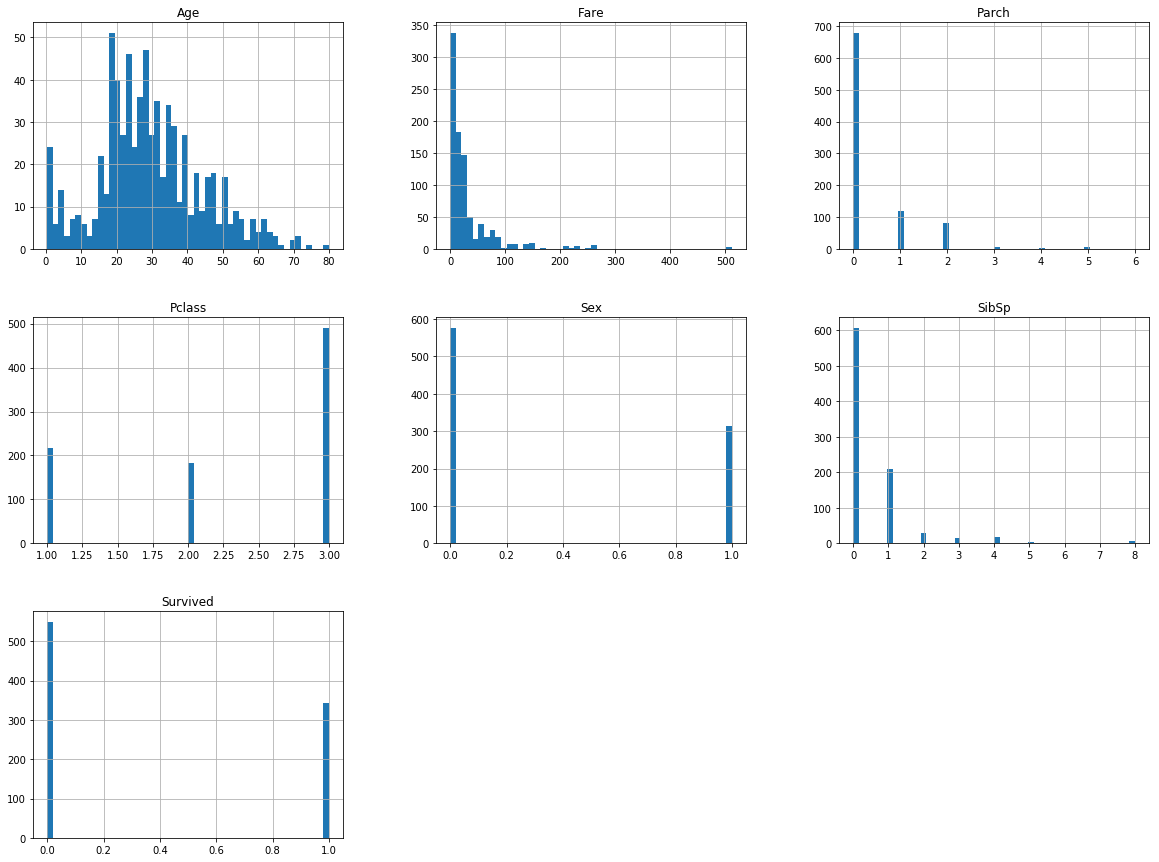

In [15]:
train.hist(bins=50, figsize=(20, 15))
plt.show()

In [16]:
corr_matrix = train.corr()

In [17]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Sex         0.543351
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [18]:
corr_matrix["Pclass"].sort_values(ascending=False)

Pclass      1.000000
SibSp       0.083081
Parch       0.018443
Sex        -0.131900
Survived   -0.338481
Age        -0.369226
Fare       -0.549500
Name: Pclass, dtype: float64

How can we fill in the missing ages? Some combination of Title and Pclass?

In [19]:
train.hist("Age", by="Title", bins=20, figsize=(20, 10), sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000E7677B2438>,
      dtype=object)

In [20]:
no_ages = np.isnan(train.Age.values)
train.loc[no_ages, "Title"].value_counts()

Mr         119
Miss        36
Mrs         17
Master       4
Medical      1
Name: Title, dtype: int64

In [21]:
pd.crosstab(train.loc[no_ages, "Title"], train.loc[no_ages, "Pclass"])

Pclass,1,2,3
Title,,,
Master,0,0,4
Medical,1,0,0
Miss,1,2,33
Mr,20,9,90
Mrs,8,0,9


In [22]:
masters = train.loc[train.Title == "Master", :]
masters.hist("Age", by="Pclass", bins=20, sharex=True, sharey=True, layout=(1, 3), figsize=(20, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000E767CECF28>,
      dtype=object)

In [23]:
masters[["Age", "Pclass"]].groupby("Pclass").median()

,Age
Pclass,
1,4.0
2,1.0
3,4.0


In [24]:
masters.hist("Age", bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000E767EB8668>]],
      dtype=object)

In [25]:
masters.Age.median()

3.5

In [26]:
medicals = train.loc[train.Title == "Medical", :]
medicals.hist("Age", by="Pclass", bins=20, sharex=True, sharey=True, layout=(1, 3), figsize=(20, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000E767FFFB00>,
      dtype=object)

In [27]:
medicals[["Age", "Pclass"]].groupby("Pclass").median()

,Age
Pclass,
1,46.5
2,38.5


In [28]:
medicals.Age.median()

46.5

In [29]:
miss = train.loc[train.Title == "Miss", :]
miss.hist("Age", by="Pclass", bins=20, sharex=True, sharey=True, layout=(1, 3), figsize=(20, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000E7686D0F28>,
      dtype=object)

In [30]:
miss[["Age", "Pclass"]].groupby("Pclass").median()

,Age
Pclass,
1,30.0
2,24.0
3,18.0


In [31]:
mr = train.loc[train.Title == "Mr", :]
mr.hist("Age", by="Pclass", bins=20, sharex=True, sharey=True, layout=(1, 3), figsize=(20, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000E7681618D0>,
      dtype=object)

In [32]:
mr[["Age", "Pclass"]].groupby("Pclass").median()

,Age
Pclass,
1,40.0
2,31.0
3,26.0


In [33]:
mrs = train.loc[train.Title == "Mrs", :]
mrs.hist("Age", by="Pclass", bins=20, sharex=True, sharey=True, layout=(1, 3), figsize=(20, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000E767830CF8>,
      dtype=object)

In [34]:
mrs[["Age", "Pclass"]].groupby("Pclass").median()

,Age
Pclass,
1,40.0
2,32.0
3,31.0


In [35]:
def get_median_age(data, person, by):
    if len(by) > 1:
        matching_params = tuple(getattr(person, attribute) for attribute in by)
    else:
        matching_params = getattr(person, by[0])
    median = data[["Age"] + by].groupby(by).median().loc[matching_params, "Age"]
    return median

In [36]:
for combo in train.loc[no_ages, ["Title", "Pclass"]].drop_duplicates().itertuples():
    print(combo)
    if combo.Title in ["Master", "Medical"]:
        median_age = get_median_age(train, combo, ["Title"])
    else:
        median_age = get_median_age(train, combo, ["Title", "Pclass"])
    print(median_age)
    train.loc[no_ages & (train.Title == combo.Title) & (train.Pclass == combo.Pclass), "Age"] = median_age

Pandas(Index=6, Title='Mr', Pclass=3)
26.0
Pandas(Index=18, Title='Mr', Pclass=2)
31.0
Pandas(Index=20, Title='Mrs', Pclass=3)
31.0
Pandas(Index=29, Title='Miss', Pclass=3)
18.0
Pandas(Index=32, Title='Mrs', Pclass=1)
40.0
Pandas(Index=56, Title='Mr', Pclass=1)
40.0
Pandas(Index=66, Title='Master', Pclass=3)
3.5
Pandas(Index=304, Title='Miss', Pclass=2)
24.0
Pandas(Index=307, Title='Miss', Pclass=1)
30.0
Pandas(Index=767, Title='Medical', Pclass=1)
46.5


How should we bin ages? Perhaps a Decision Tree can give us reasonable splits that have significantly different survival rates.

In [37]:
surv_by_age = train[["Age", "Survived"]].groupby("Age").mean()
plt.scatter(surv_by_age.index.values, surv_by_age.values)

In [38]:
params = {
    "max_depth": list(range(1, 4))
}
random_search_cv = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=6, verbose=1)
random_search_cv.fit(train.Age.values.reshape(-1, 1), train.Survived)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=6)]: Done   9 out of   9 | elapsed:    4.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [1, 2, 3]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [39]:
random_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
export_graphviz(
    random_search_cv.best_estimator_,
    out_file="age_tree.dot",
    feature_names=["Age"],
    class_names=["Died", "Survived"],
    rounded=True,
    filled=True
)

Our best estimate shows gives us 2, 3, or 4 age cutoffs:
* <= 0.96 (Small population size)
* <= 6.5
* <= 68
* \> 68 (Small population size)

Can we do anything with the cabin numbers? Looks like the first letter is the deck level.

In [41]:
train["Deck"] = train.Cabin.astype(str).str[0]

In [42]:
train[["Deck", "Survived"]].groupby("Deck").mean().sort_values(by="Survived", ascending=False)

,Survived
Deck,
D,0.757576
E,0.750000
B,0.744681
F,0.615385
C,0.593220
G,0.500000
A,0.466667
n,0.299854
T,0.000000


In [43]:
pd.crosstab(train["Deck"], train["Pclass"])

Pclass,1,2,3
Deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0
n,40,168,479


In [44]:
cabins = train.loc[train.Cabin.notnull(), :]

In [45]:
cabins[["Deck", "Survived"]].groupby("Deck").mean().sort_values(by="Survived", ascending=False)

,Survived
Deck,
D,0.757576
E,0.750000
B,0.744681
F,0.615385
C,0.593220
G,0.500000
A,0.466667
T,0.000000


In [46]:
cabins.Deck.value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64

In [47]:
pd.crosstab(cabins["Deck"], cabins["Pclass"])

Pclass,1,2,3
Deck,,,
A,15,0,0
B,47,0,0
C,59,0,0
D,29,4,0
E,25,4,3
F,0,8,5
G,0,0,4
T,1,0,0


### The naive approach
Let's just setup a basic pipeline to get a minimal model working. We can then add new or change pieces to improve our model.

In [63]:
def make_data():
    train = pd.read_csv("data/train.csv", index_col=0)
    train_X = train.drop("Survived", axis=1).copy()
    train_y = train["Survived"].copy()
    return train_X, train_y

In [49]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.loc[:, self.attribute_names]

In [50]:
class CategoryFactorizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoded = X.factorize()[0].reshape(-1, 1)
        return encoded

In [95]:
class GenerateTitles(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Check if the titles have already been added (Title and Age pipelines both add the column)
        if "Title" in X.columns:
            return X
        X["Title"] = X.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        title_mapping = {
            "Mlle": "Miss", "Mme": "Mrs", "Ms": "Miss", "Capt": "Military", "Col": "Military", "Major": "Military", 
            "Countess": "Nobility", "Don": "Nobility", "Dr": "Medical", "Jonkheer": "Nobility", "Lady": "Nobility",
            "Rev": "Religous", "Sir": "Nobility",
        }
        for from_title, to_title in title_mapping.items():    
            X.loc[X.Title == from_title, "Title"] = to_title
        return X

In [52]:
class AgeImputerByTitlePclass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        no_ages = np.isnan(X.Age.values)
        for combo in X.loc[no_ages, ["Title", "Pclass"]].drop_duplicates().itertuples():
            if combo.Title in ["Master", "Medical"]:
                median_age = self.get_median_age(train, combo, ["Title"])
            else:
                median_age = self.get_median_age(train, combo, ["Title", "Pclass"])
            X.loc[no_ages & (X.Title == combo.Title) & (X.Pclass == combo.Pclass), "Age"] = median_age
        return X
    
    @staticmethod
    def get_median_age(data, person, by):
        if len(by) > 1:
            matching_params = tuple(getattr(person, attribute) for attribute in by)
        else:
            matching_params = getattr(person, by[0])
        median = data[["Age"] + by].groupby(by).median().loc[matching_params, "Age"]
        return median

In [53]:
class Binner(BaseEstimator, TransformerMixin):
    def __init__(self, column, bin_right_edges):
        self.column = column
        self.bin_right_edges = bin_right_edges
        self.num_bins = len(bin_right_edges) + 1
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        binned = np.full(X.shape[0], self.num_bins)
        for i, bin_max in enumerate(reversed(self.bin_right_edges)):
            binned[X[self.column].values < bin_max] = self.num_bins - i - 1
        X[self.column] = binned
        return X

In [54]:
def numerics_pipeline(attribute_names, scaling=False):
    pieces = [
        ('selector', DataFrameSelector(attribute_names)),
        ('imputer', Imputer(strategy="median")),  # For lazily imputing Age
    ]
    if scaling:
        pieces.append(('std_scaler', StandardScaler()))
    return Pipeline(pieces)

In [55]:
def str_category_pipeline(attribute_name):
    return Pipeline([
        ('selector', DataFrameSelector(attribute_name)),
        ('factorize', CategoryFactorizer()),
        ('imputer', Imputer(missing_values=-1, strategy="most_frequent")),  # This is here for Embarked
        ('one_hot', OneHotEncoder())
    ])

In [56]:
def ordinal_category_pipeline(attribute_name):
    return Pipeline([
        ('selector', DataFrameSelector(attribute_name)),
        ('one_hot', OneHotEncoder())
    ])

In [98]:
def age_pipeline(bin_right_edges):
    return Pipeline([
        ('titler', GenerateTitles()),
        ('selector', DataFrameSelector(["Age", "Title", "Pclass"])),
        ('imputer', AgeImputerByTitlePclass()),
        ('age_selector', DataFrameSelector(["Age"])),
        ('bin', Binner("Age", bin_right_edges)),
        ('one_hot', OneHotEncoder())
    ])

In [58]:
def title_pipeline():
    return Pipeline([
        ('titler', GenerateTitles()),
        ('selector', DataFrameSelector("Title")),
        ('factorize', CategoryFactorizer()),
        ('one_hot', OneHotEncoder())
    ])

In [68]:
def display_scores(scores):
    print("Mean Accuracy:", scores.mean())
    print("Standard deviation:", scores.std())

In [60]:
def test_model(model, X, y):
    scores = cross_val_score(model, X, y, scoring="accuracy", n_jobs=6)
    display_scores(scores)

In [61]:
def test_pipeline(pipeline):
    X_og, y = make_data()
    X = pipeline.fit_transform(X_og)
    print("Logistic Regression")
    print("===================")
    test_model(LogisticRegression(), X, y)
    print()
    print("Random Forest")
    print("=============")
    test_model(RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=5), X, y)

#### Test a bunch of different models

In [64]:
train_X, train_y = make_data()

In [65]:
naive_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "Pclass", "SibSp"])),
    ("num_scale_pipeline", numerics_pipeline(["Age", "Fare"], scaling=True)),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
])
train_X_prep = naive_pipeline.fit_transform(train_X)

In [69]:
test_model(LogisticRegression(), train_X_prep, train_y)

Mean Accuracy: 0.7878787878787877
Standard deviation: 0.002749146737130378


In [70]:
test_model(SGDClassifier(max_iter=5, tol=None), train_X_prep, train_y)

Mean Accuracy: 0.7643097643097643
Standard deviation: 0.0317047068278912


In [71]:
test_model(LinearSVC(C=1, loss="hinge"), train_X_prep, train_y)

Mean Accuracy: 0.787878787878788
Standard deviation: 0.011983252808115947


In [72]:
# This takes forever to run
# test_model(SVC(kernel="poly", degree=3, coef0=1, C=5), train_X_prep, train_y)

In [73]:
test_model(SVC(kernel="rbf", gamma=5, C=0.001), train_X_prep, train_y)

Mean Accuracy: 0.6161616161616161
Standard deviation: 0.0


In [74]:
test_model(DecisionTreeClassifier(), train_X_prep, train_y)

Mean Accuracy: 0.7598204264870931
Standard deviation: 0.020633867913412155


In [75]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = LinearSVC(C=1, loss="hinge")

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
test_model(voting_clf, train_X_prep, train_y)

Mean Accuracy: 0.7957351290684626
Standard deviation: 0.005722805290227617


In [76]:
# Can do boostrap=False for Pasting

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), 
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=4
)
test_model(bag_clf, train_X_prep, train_y)

Mean Accuracy: 0.809203142536476
Standard deviation: 0.015141119599587062


In [77]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=4)
test_model(rnd_clf, train_X_prep, train_y)

Mean Accuracy: 0.8181818181818182
Standard deviation: 0.00991218952449815


In [78]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
)
test_model(ada_clf, train_X_prep, train_y)

Mean Accuracy: 0.8002244668911337
Standard deviation: 0.030282239199174072


In [79]:
gb_clf = GradientBoostingClassifier(max_depth=2, n_estimators=200)
test_model(gb_clf, train_X_prep, train_y)

Mean Accuracy: 0.8204264870931537
Standard deviation: 0.030406772579447957


#### Test a bunch of different pipelines

In [81]:
no_scale_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "Pclass", "SibSp", "Age", "Fare"])),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
])
test_pipeline(no_scale_pipeline)

Logistic Regression
Mean Accuracy: 0.7890011223344556
Standard deviation: 0.0015872206087240053

Random Forest
Mean Accuracy: 0.8170594837261503
Standard deviation: 0.010408101566212916


In [82]:
scale_fare_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "Pclass", "SibSp", "Age"])),
    ("num_scale_pipeline", numerics_pipeline(["Fare"], scaling=True)),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
])
test_pipeline(scale_fare_pipeline)

Logistic Regression
Mean Accuracy: 0.7912457912457912
Standard deviation: 0.004761661826172068

Random Forest
Mean Accuracy: 0.8136924803591471
Standard deviation: 0.006918534234533093


In [83]:
scale_both_pipeline = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "Pclass", "SibSp"])),
    ("num_scale_pipeline", numerics_pipeline(["Fare", "Age"], scaling=True)),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
])
test_pipeline(scale_both_pipeline)

Logistic Regression
Mean Accuracy: 0.7878787878787877
Standard deviation: 0.002749146737130378

Random Forest
Mean Accuracy: 0.8136924803591471
Standard deviation: 0.008398782012960598


In [84]:
one_hot_pclass = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "SibSp"])),
    ("num_scale_pipeline", numerics_pipeline(["Fare", "Age"], scaling=True)),
    ("ord_to_one_hot", ordinal_category_pipeline(["Pclass"])),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
])
test_pipeline(one_hot_pclass)

Logistic Regression
Mean Accuracy: 0.7912457912457912
Standard deviation: 0.0072735585840716915

Random Forest
Mean Accuracy: 0.8170594837261503
Standard deviation: 0.012697764869792095


In [85]:
more_one_hots = FeatureUnion(transformer_list=[
    ("num_scale_pipeline", numerics_pipeline(["Fare", "Age"], scaling=True)),
    ("ord_to_one_hot", ordinal_category_pipeline(["Parch", "Pclass", "SibSp"])),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
])
test_pipeline(more_one_hots)

Logistic Regression
Mean Accuracy: 0.8024691358024691
Standard deviation: 0.0031744412174480106

Random Forest
Mean Accuracy: 0.8114478114478114
Standard deviation: 0.017168415870682747


#### Start messing with feature selection

In [91]:
add_title = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "SibSp"])),
    ("num_scale_pipeline", numerics_pipeline(["Fare", "Age"], scaling=True)),
    ("ord_to_one_hot", ordinal_category_pipeline(["Pclass"])),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
    ("title_generation", title_pipeline()),
])
test_pipeline(add_title)

Logistic Regression
Mean Accuracy: 0.8193041526374859
Standard deviation: 0.006348882434896073

Random Forest
Mean Accuracy: 0.8226711560044894
Standard deviation: 0.009654686046063553


In [92]:
title_no_scaling = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "SibSp", "Fare", "Age"])),
    ("ord_to_one_hot", ordinal_category_pipeline(["Pclass"])),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
    ("title_generation", title_pipeline()),
])
test_pipeline(title_no_scaling)

Logistic Regression
Mean Accuracy: 0.8204264870931537
Standard deviation: 0.006918534234533098

Random Forest
Mean Accuracy: 0.8271604938271606
Standard deviation: 0.0129919606091922


In [99]:
bin_age = FeatureUnion(transformer_list=[
    ("num_no_scale_pipeline", numerics_pipeline(["Parch", "SibSp"])),
    ("num_scale_pipeline", numerics_pipeline(["Fare"], scaling=True)),
    ("ord_to_one_hot", ordinal_category_pipeline(["Pclass"])),
    ("sex_pipeline", str_category_pipeline("Sex")),
    ("embarked_pipeline", str_category_pipeline("Embarked")),
    ("title_generation", title_pipeline()),
    ("age_pipeline", age_pipeline([0.96, 6.5, 68.0])),
])
test_pipeline(bin_age)

Logistic Regression
Mean Accuracy: 0.8181818181818182
Standard deviation: 0.015306601231185003

Random Forest
Mean Accuracy: 0.8193041526374859
Standard deviation: 0.008398782012960598


In [90]:
# Change Parch and SipSp to family size

In [93]:
# Add deck assignments